In [1]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

from ipywidgets import interactive
from collections import defaultdict

import hdbscan
import folium
import re

cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080']*10
sns.set(style="white")

In [2]:
df = pd.read_csv('twitter_posts.csv')
df.head()

Date         Username  longitude   latitude  \
0  2023-03-18 16:28:04+00:00          RokebyM  67.997691   6.622513   
1  2023-03-18 11:20:07+00:00          watwijm  94.944302  26.649359   
2  2023-03-18 11:05:10+00:00  travelwitharyan  72.206516  27.698326   
3  2023-03-18 11:03:32+00:00  travelwitharyan  72.206516  27.698326   
4  2023-03-18 08:44:42+00:00  NSivapriyan2141  77.312066   8.230492   

                city country  
0             India'   India  
1  Arunachal Pradesh   India  
2            Bikaner   India  
3            Bikaner   India  
4    Padmanabhapuram   India

### Dropping NaN and Duplicates

In [3]:
print(f'Before dropping values\t:\tdf.shape = {df.shape}')
df.dropna(inplace=True)
df.drop_duplicates(subset = ['latitude','longitude'], keep='first', inplace=True)
print(f'After dropping values\t:\tdf.shape = {df.shape}')

Before dropping values	:	df.shape = (1803, 6)
After dropping values	:	df.shape = (604, 6)


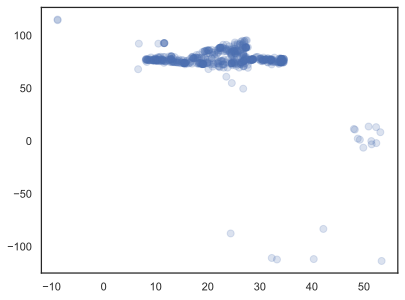

In [4]:
X = np.array(df[['latitude', 'longitude']], dtype='float64')
plt.scatter(X[:,0], X[:,1], alpha=0.2, s=50)

In [5]:
m = folium.Map(location=[df.latitude.mean(), df.longitude.mean()], zoom_start=9, tiles='OpenStreet Map')

for _, row in df.iterrows():
    folium.CircleMarker(location=[row.latitude, row.longitude], radius = 5, popup=row['city'], color = '#1787FE',fill=True, fill_colour='#1787FE').add_to(m)
    
m

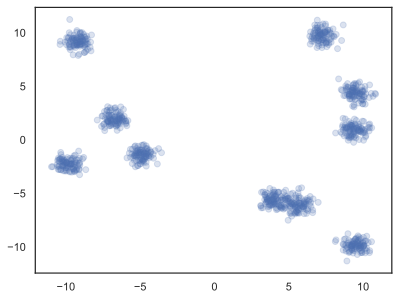

In [6]:
X_blobs,_ = make_blobs(n_samples=1000,centers=10, n_features=2, cluster_std=0.5, random_state=4)
plt.scatter(X_blobs[:,0], X_blobs[:,1], alpha = 0.2)

In [7]:
class_predictions = np.load('sample_clusters.npy')

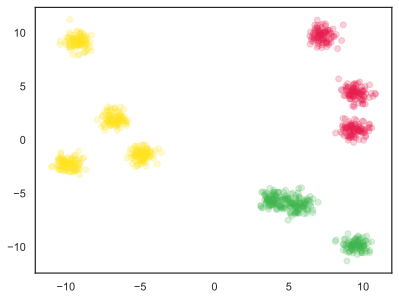

In [8]:
unique_clusters = np.unique(class_predictions)
for unique_cluster in unique_clusters:
    X = X_blobs[class_predictions==unique_cluster]
    plt.scatter(X[:,0],X[:,1], alpha=0.2, c=cols[unique_cluster])

In [9]:
silhouette_score(X_blobs,class_predictions)

0.6657220862867241

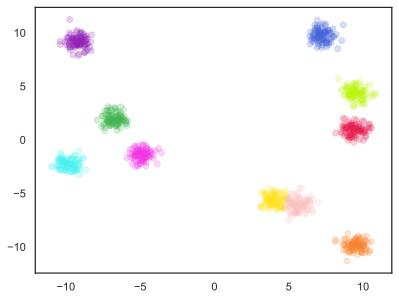

In [10]:
class_predictions = np.load('sample_clusters_improved.npy')
unique_clusters = np.unique(class_predictions)
for unique_cluster in unique_clusters:
    X = X_blobs[class_predictions==unique_cluster]
    plt.scatter(X[:,0], X[:,1], alpha=0.2, c=cols[unique_cluster])

In [11]:
silhouette_score(X_blobs,class_predictions)

0.7473587799908298

## K-Means Clustering

In [12]:
X_blobs,_ = make_blobs(n_samples=1000, centers=50, n_features=2, cluster_std=1,random_state=4)

In [13]:
data= defaultdict(dict)

for x in range(1,21):
    model = KMeans(n_clusters=3, random_state=17, max_iter=x, n_init=1).fit(X_blobs)
    
    data[x]['class_predictions'] = model.predict(X_blobs)
    data[x]['centroids'] = model.cluster_centers_
    data[x]['unique_classes'] = np.unique(class_predictions)

In [14]:
def f(x):
    
    class_predictions = data[x]['class_predictions']
    centroids = data[x]['centroids']
    unique_classes = data[x]['unique_classes']
    
    for unique_class in unique_classes:
        plt.scatter(X_blobs[class_predictions == unique_class][:,0],
                   X_blobs[class_predictions==unique_class][:,1],
                   alpha=0.3, c=cols[unique_class])
        
    plt.scatter(centroids[:,0], centroids[:,1], s=200, c='#000000', marker='v')
    plt.ylim([-15,15]); plt.xlim([-15,15])
    plt.title('How K-Means Clusters')
    

interactive_plot = interactive(f,x=(1,10))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=5, description='x', max=10, min=1), Output(layout=Layout(height='350px')…

In [15]:
X = np.array(df[['longitude', 'latitude']], dtype='float64')
k = 70
model = KMeans(n_clusters=k, random_state=17).fit(X)
class_predictions = model.predict(X)
df[f'CLUSTER_kmeans{k}'] = class_predictions

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [16]:
df['CLUSTER_kmeans70'].max()

69

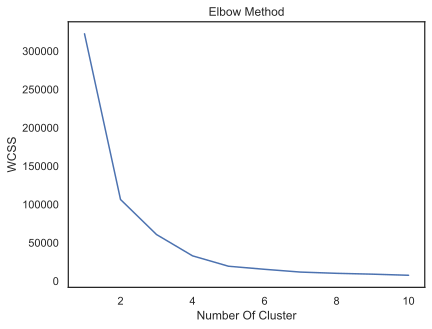

In [17]:
wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300,n_init=10,random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number Of Cluster')
plt.ylabel('WCSS')
plt.show()

In [18]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)

In [19]:
df['clusters_kmeans_final'] = pred_y

In [20]:
df.head()

Date         Username  longitude   latitude  \
0  2023-03-18 16:28:04+00:00          RokebyM  67.997691   6.622513   
1  2023-03-18 11:20:07+00:00          watwijm  94.944302  26.649359   
2  2023-03-18 11:05:10+00:00  travelwitharyan  72.206516  27.698326   
4  2023-03-18 08:44:42+00:00  NSivapriyan2141  77.312066   8.230492   
5  2023-03-17 14:38:59+00:00    tourism_udupi  74.667323  13.086056   

                city country  CLUSTER_kmeans70  clusters_kmeans_final  
0             India'   India                33                      0  
1  Arunachal Pradesh   India                16                      0  
2            Bikaner   India                63                      0  
4    Padmanabhapuram   India                 8                      0  
5              Udupi   India                23                      0

In [21]:
def create_map(df, cluster_column):
    m = folium.Map(location=[df.latitude.mean(), df.longitude.mean()], zoom_start=9, titles='OpenStreet Map')
    
    for _, row in df.iterrows():
        if row[cluster_column] == -1:
            cluster_color = '#000000'
        else:
            cluster_color = cols[row[cluster_column]]
        
        folium.CircleMarker(location=[row['latitude'], row['longitude']],
                           radius=5,
                           popup= row[cluster_column],
                           color=cluster_color,
                           fill=True,
                           fill_color = cluster_color).add_to(m)
    return m

m = create_map(df,'CLUSTER_kmeans70')

print(f'K={k}')
print(f'Silhouette Score: {silhouette_score(X,class_predictions)}')


K=70
Silhouette Score: 0.5020110718161712


In [22]:
test_map = create_map(df, 'clusters_kmeans_final')
print(f'Silhouette Score: {silhouette_score(X,pred_y)}')

Silhouette Score: 0.8828104815384913


In [23]:
test_map

In [24]:
m

In [25]:
best_silhouette, best_k = -1,0

for k in tqdm(range(2,100)):
    
    model = KMeans(n_clusters=k, random_state=1).fit(X)
    class_predictions = model.predict(X)
    
    curr_silhouette = silhouette_score(X,class_predictions)
    if curr_silhouette > best_silhouette:
        best_k = k
        best_silhouette = curr_silhouette

print(f'K={best_k}')
print(f'Silhouette Score: {best_silhouette}')


  0%|                                                    | 0/98 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  2%|▉                                           | 2/98 [00:00<00:06, 15.36it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/P

 27%|███████████▍                               | 26/98 [00:02<00:11,  6.48it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 28%|███████████▊                               | 27/98 [00:03<00:11,  6.25it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 29%|████████████▎                              | 28/98 [00:03<00:11,  6.16it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n

 50%|█████████████████████▌                     | 49/98 [00:07<00:13,  3.56it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 51%|█████████████████████▉                     | 50/98 [00:08<00:12,  3.85it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 52%|██████████████████████▍                    | 51/98 [00:08<00:11,  3.96it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n

 73%|███████████████████████████████▌           | 72/98 [00:14<00:07,  3.41it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 74%|████████████████████████████████           | 73/98 [00:14<00:07,  3.35it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 76%|████████████████████████████████▍          | 74/98 [00:14<00:07,  3.29it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n

 97%|█████████████████████████████████████████▋ | 95/98 [00:22<00:01,  2.68it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 98%|██████████████████████████████████████████ | 96/98 [00:22<00:00,  2.64it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 99%|██████████████████████████████████████████▌| 97/98 [00:23<00:00,  2.56it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n

K=2
Silhouette Score: 0.8828104815384913


### DBSCAN

In [26]:
dummy = np.array([-1, -1, -1, 2, 3, 4, 5,-1])
new = np.array([(counter+2)*x if x == -1 else x for counter, x in enumerate(dummy)])

In [27]:
model = DBSCAN(eps=0.01, min_samples=5).fit(X)
class_predictions = model.labels_
df['CLUSTERS_DBSCAN'] = class_predictions

In [28]:
m = create_map(df, 'CLUSTERS_DBSCAN')

print(f'Number of Clusters found: {len(np.unique(class_predictions))}')
print(f'Number of Outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette Ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

Number of Clusters found: 3
Number of Outliers found: 588
Silhouette Ignoring outliers: 0.9994074658745187
Silhouette outliers as singletons: 0.01794606228669233


In [29]:
m

### HDBSCAN

In [30]:
model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2, cluster_selection_epsilon=0.01)

class_predictions = model.fit_predict(X)
df['CLUSTER_HDBSCAN'] = class_predictions

In [32]:
df.head()

Date         Username  longitude   latitude  \
0  2023-03-18 16:28:04+00:00          RokebyM  67.997691   6.622513   
1  2023-03-18 11:20:07+00:00          watwijm  94.944302  26.649359   
2  2023-03-18 11:05:10+00:00  travelwitharyan  72.206516  27.698326   
4  2023-03-18 08:44:42+00:00  NSivapriyan2141  77.312066   8.230492   
5  2023-03-17 14:38:59+00:00    tourism_udupi  74.667323  13.086056   

                city country  CLUSTER_kmeans70  clusters_kmeans_final  \
0             India'   India                33                      0   
1  Arunachal Pradesh   India                16                      0   
2            Bikaner   India                63                      0   
4    Padmanabhapuram   India                 8                      0   
5              Udupi   India                23                      0   

   CLUSTERS_DBSCAN  CLUSTER_HDBSCAN  
0               -1               -1  
1               -1                5  
2               -1               -1  
4               -1               37  
5               -1               35

In [33]:
m = create_map(df, 'CLUSTER_HDBSCAN')
print(f'Number of clusters found: {len(np.unique(class_predictions))-1}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

Number of clusters found: 45
Number of outliers found: 179
Silhouette ignoring outliers: 0.6313496724495851
Silhouette outliers as singletons: 0.32057324658134406


In [34]:
m

In [ ]:
hdbscan.HDBSCAN?

### Addressing Outliers

In [35]:
classifier = KNeighborsClassifier(n_neighbors=1)

In [36]:
df_train = df[df.CLUSTER_HDBSCAN != 1]
df_predict = df[df.CLUSTER_HDBSCAN==-1]

In [37]:
X_train = np.array(df_train[['longitude', 'latitude']], dtype='float64')
y_train = np.array(df_train['CLUSTER_HDBSCAN'])
X_predict = np.array(df_predict[['longitude', 'latitude']], dtype='float64')

In [38]:
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [39]:
predictions = classifier.predict(X_predict)

In [40]:
df['CLUSTER_hybrid'] = df['CLUSTER_HDBSCAN']

In [41]:
df.loc[df.CLUSTER_HDBSCAN==-1, 'CLUSTER_hybrid'] = predictions

In [42]:
m = create_map(df, 'CLUSTER_hybrid')

In [43]:
m

In [44]:
df.head()

Date         Username  longitude   latitude  \
0  2023-03-18 16:28:04+00:00          RokebyM  67.997691   6.622513   
1  2023-03-18 11:20:07+00:00          watwijm  94.944302  26.649359   
2  2023-03-18 11:05:10+00:00  travelwitharyan  72.206516  27.698326   
4  2023-03-18 08:44:42+00:00  NSivapriyan2141  77.312066   8.230492   
5  2023-03-17 14:38:59+00:00    tourism_udupi  74.667323  13.086056   

                city country  CLUSTER_kmeans70  clusters_kmeans_final  \
0             India'   India                33                      0   
1  Arunachal Pradesh   India                16                      0   
2            Bikaner   India                63                      0   
4    Padmanabhapuram   India                 8                      0   
5              Udupi   India                23                      0   

   CLUSTERS_DBSCAN  CLUSTER_HDBSCAN  CLUSTER_hybrid  
0               -1               -1              -1  
1               -1                5               5  
2               -1               -1              -1  
4               -1               37              37  
5               -1               35              35

In [45]:
class_predictions = df.CLUSTER_hybrid
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Silhouette: {silhouette_score(X, class_predictions)}')

m.save('hybrid.html')

Number of clusters found: 46
Silhouette: 0.1930880444465352


Text(0.5, 0, 'Cluster Sizes')

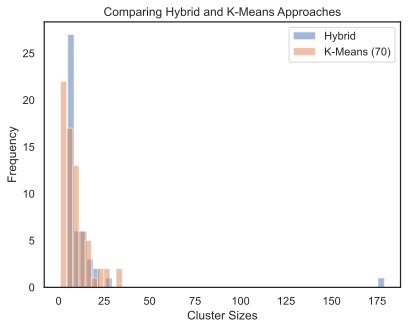

In [46]:
df['CLUSTER_hybrid'].value_counts().plot.hist(bins=50, alpha=0.5, 
                                              label='Hybrid')
df['CLUSTER_kmeans70'].value_counts().plot.hist(bins=10, alpha=0.5,
                                               label='K-Means (70)')
plt.legend()
plt.title('Comparing Hybrid and K-Means Approaches')
plt.xlabel('Cluster Sizes')

#####  Drop countries != INDIA

In [49]:
# from sklearn.cluster import KMeans
# from sklearn.cluster import DBSCAN
from hdbscan import HDBSCAN
# import numpy as np

def hybrid_clustering(X, k, eps, min_samples, min_cluster_size):
    # Step 1: Perform K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    # Step 2: Identify core samples and non-core samples using DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_samples_mask[dbscan.core_sample_indices_] = True
    db_labels = dbscan.labels_

    # Step 3: Perform HDBSCAN clustering on core samples
    hdbscan = HDBSCAN(min_cluster_size=min_cluster_size).fit(X[core_samples_mask])
    hdbscan_labels = hdbscan.labels_

    # Step 4: Combine cluster labels from all clustering methods
    final_labels = np.zeros_like(labels)
    for i in range(len(labels)):
        if core_samples_mask[i]:
            final_labels[i] = hdbscan_labels[np.where(np.array(kmeans.predict([X[i]])) == kmeans.labels_[i])[0][0]] + np.max(db_labels) + 1
        else:
            final_labels[i] = db_labels[i] + np.max(hdbscan.labels_) + 1
            
    return final_labels


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

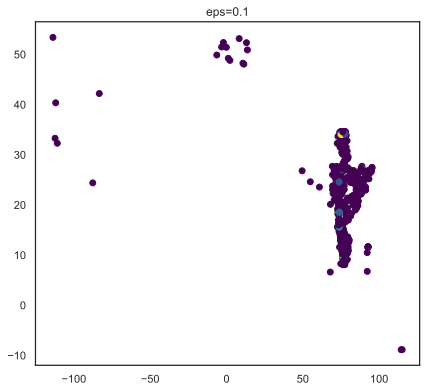

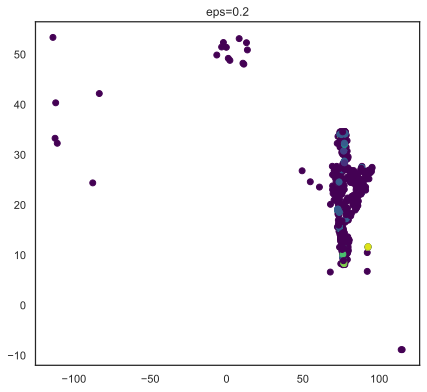

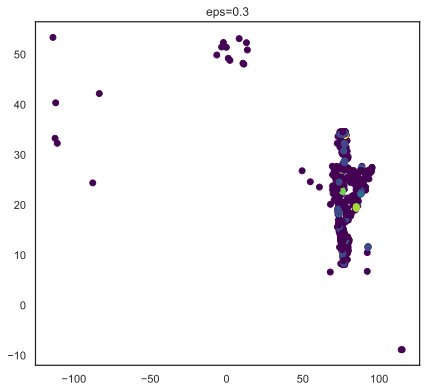

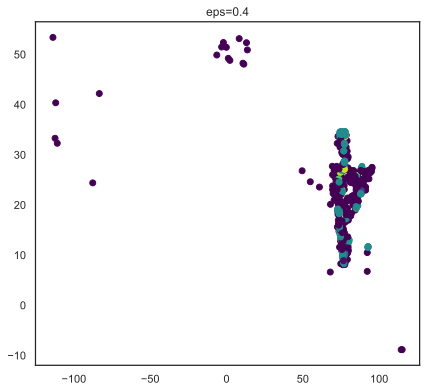

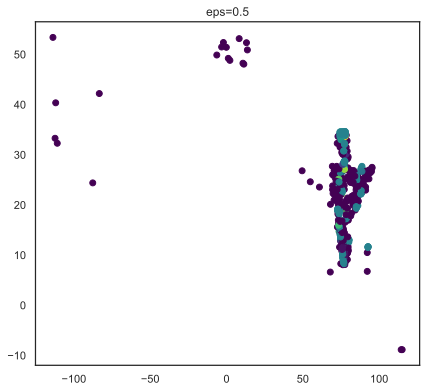

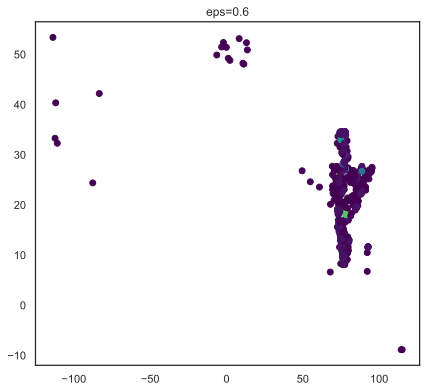

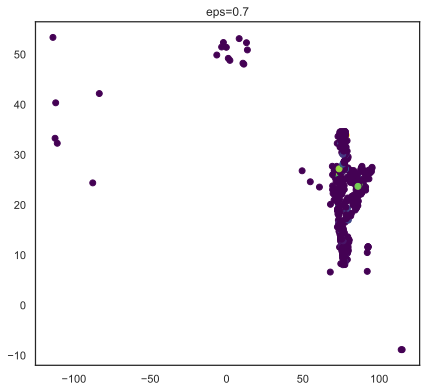

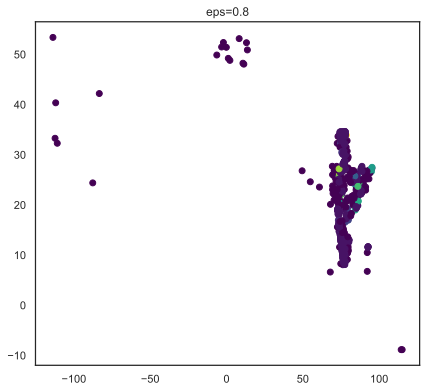

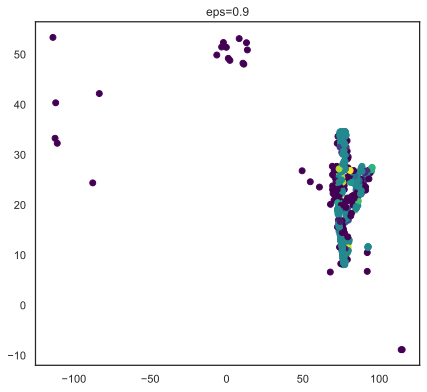

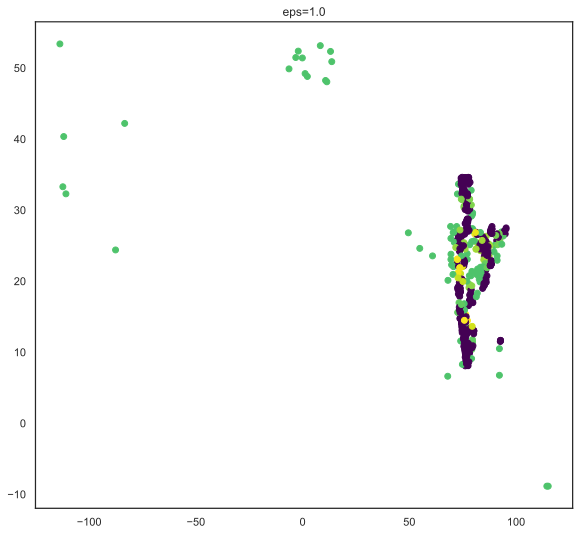

In [83]:
eps_values = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

for i, eps in enumerate(eps_values):
    hybrid_cluster = hybrid_clustering(X, 2, eps, 5, 2)
    
    plt.figure(figsize=(40,36))

    plt.subplot(5, 5, i+1)
    plt.scatter(X[:, 0], X[:, 1], c=hybrid_cluster, cmap='viridis')
    plt.title(f'eps={eps}')

plt.tight_layout()
plt.show()


In [73]:
df['hybrid_cluster'] = hybrid_cluster

In [74]:
df.head(20)

Date         Username  longitude   latitude  \
0   2023-03-18 16:28:04+00:00          RokebyM  67.997691   6.622513   
1   2023-03-18 11:20:07+00:00          watwijm  94.944302  26.649359   
2   2023-03-18 11:05:10+00:00  travelwitharyan  72.206516  27.698326   
4   2023-03-18 08:44:42+00:00  NSivapriyan2141  77.312066   8.230492   
5   2023-03-17 14:38:59+00:00    tourism_udupi  74.667323  13.086056   
6   2023-03-17 12:05:03+00:00         onsvlogs  85.832496  21.544342   
8   2023-03-17 02:31:04+00:00    jaydeep_dey03  90.939097  25.722728   
9   2023-03-16 16:16:44+00:00  flywithheritage  77.882808  30.227984   
11  2023-03-16 10:07:08+00:00      Hyd_Library  78.233173  17.237105   
15  2023-03-16 05:55:10+00:00    BhanwalaVinit  76.994604  28.080602   
17  2023-03-16 01:08:13+00:00  cartoonistarvin  76.317532  32.190952   
18  2023-03-15 16:30:15+00:00    Nirajksingh21  84.956937  24.673368   
22  2023-03-15 14:39:56+00:00     raihanhaque7  88.390681  22.492584   
24  2023-03-15 14:00:58+00:00       SKesari_22  84.292829  24.286947   
26  2023-03-15 06:44:16+00:00   BBC_travelogue  87.413715  23.539988   
29  2023-03-15 04:32:53+00:00          O_arra_  76.992563  30.918767   
30  2023-03-14 19:31:11+00:00     Sudhanshu_MK  84.993910  25.483546   
31  2023-03-14 16:15:06+00:00  AJAYKUM95362816  83.331271  21.970758   
32  2023-03-14 10:26:12+00:00        vtouring1  76.938730  31.720993   
33  2023-03-14 06:33:21+00:00        regilkool  88.444115  27.137137   

                 city country  CLUSTER_kmeans70  clusters_kmeans_final  \
0              India'   India                33                      0   
1   Arunachal Pradesh   India                16                      0   
2             Bikaner   India                63                      0   
4     Padmanabhapuram   India                 8                      0   
5               Udupi   India                23                      0   
6         West Bengal   India                69                      0   
8            Guwahati   India                36                      0   
9            Dehradun   India                46                      0   
11     Rajendra Nagar   India                21                      0   
15                Nuh   India                27                      0   
17          Dharmsala   India                56                      0   
18           Bodhgaya   India                24                      0   
22       Bidhan Nagar   India                25                      0   
24               Gaya   India                58                      0   
26       Santiniketan   India                57                      0   
29             Shimla   India                59                      0   
30              Patna   India                24                      0   
31          Jharkhand   India                 4                      0   
32   Kullu and Manali   India                 3                      0   
33            Gangtok   India                20                      0   

    CLUSTERS_DBSCAN  CLUSTER_HDBSCAN  CLUSTER_hybrid  hybrid_cluster  
0                -1               -1              -1              42  
1                -1                5               5              42  
2                -1               -1              -1              42  
4                -1               37              37              53  
5                -1               35              35              53  
6                -1               -1              -1              42  
8                -1                5               5              42  
9                -1               27              27              53  
11               -1                6               6              53  
15               -1               -1              -1              53  
17               -1               31              31              53  
18               -1               28              28              51  
22               -1               

In [75]:
hybrid_map = create_map(df, 'hybrid_cluster')

In [76]:
hybrid_map

### NLP lcustering analysis

In [ ]:
nlp_places_df = pd.read_csv('Locations.csv')

In [ ]:
print(f'Before dropping values\t:\tnlp_places_df.shape = {nlp_places_df.shape}')
nlp_places_df.dropna(inplace=True)
nlp_places_df.drop_duplicates(subset = ['Place'], keep='first', inplace=True)
print(f'After dropping values\t:\tnlp_places_df.shape = {nlp_places_df.shape}')

In [ ]:
test_df = nlp_places_df

In [ ]:
import geopy
from geopy.geocoders import Nominatim
import time

df_new = pd.DataFrame(columns=['longitude', 'latitude', 'City'])

geolocator = Nominatim(user_agent="my-app")
for index, row in nlp_places_df.iterrows():
    city = row['Place']
    while True:
        try:
            location = geolocator.geocode(city, timeout=10)
            if location:
                longitude = location.longitude
                latitude = location.latitude
                df_new = df_new.append({'longitude': longitude, 'latitude': latitude, 'Place': city}, ignore_index=True)
        
            break
        except geopy.exc.GeocoderUnavailable:
            print('Geocoder is unavailable. Waiting for 5 seconds before trying again...')
            time.sleep(5)
    
        


In [ ]:
df_new.head(20)

In [ ]:
df_new.shape

In [ ]:
np.savetxt("Locations.csv", df_new, delimiter=", ", fmt="%s")

In [ ]:
final_dataframe = pd.read_csv('Locations.csv')

In [ ]:
final_dataframe.head()

In [ ]:
final_dataframe['Cluster_HDBSCAN'] = model.fit_predict(final_dataframe[['longitude', 'latitude']])

In [ ]:
final_dataframe.head(20)

In [ ]:
final_df_train = final_dataframe[final_dataframe.Cluster_HDBSCAN != 1]
final_df_predict = final_dataframe[final_dataframe.Cluster_HDBSCAN==-1]

In [ ]:
X_train_predict = np.array(final_df_train[['longitude', 'latitude']], dtype='float64')
y_train_predict = np.array(final_df_train['Cluster_HDBSCAN'])
X_predict_final = np.array(final_df_predict[['longitude', 'latitude']], dtype='float64')

In [ ]:
classifier.fit(X_train_predict, y_train_predict)

In [ ]:
final_predictions = classifier.predict(X_predict_final)

In [ ]:
final_dataframe['CLUSTER_hybrid'] = final_dataframe['Cluster_HDBSCAN']

In [ ]:
final_dataframe.loc[final_dataframe.Cluster_HDBSCAN==-1, 'CLUSTER_hybrid'] = final_predictions

In [ ]:
import json
folium_map = folium.Map(location=[final_dataframe['latitude'].mean(), final_dataframe['longitude'].mean()], zoom_start=10, tiles='OpenStreet Map')

marker_group = folium.FeatureGroup(name = 'Markers')
for i, row in final_dataframe.iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup=row['Place']).add_to(marker_group)
    
marker_group.add_to(folium_map)


cluster_geos = {}
for cluster_id in final_dataframe['CLUSTER_hybrid'].unique():
    cluster_name = f'Cluster {cluster_id}'
    cluster_features = []
    for i, row in final_dataframe[final_dataframe['CLUSTER_hybrid'] == cluster_id].iterrows():
        features = {
            'type':'Feature',
            'geometry':{'type': 'Point', 'coordinates': [row['longitude'], row['latitude']]
                       },
            'properties': {
                'name': row['Place']
            }
        }
        cluster_features.append(features)
    cluster_geo = {
        'type':'FeatureCollection',
        'feature': cluster_features
    }
    cluster_geos[cluster_name] = cluster_geo
    
    
    

search_box = '<input type="text" placeholder="Enter a city name" oninput="search(this.value)">'
html = f'<div style="position:absolute; z-index:9999; background-color:white; padding:10px">{search_box}</div>'

folium_map.get_root().html.add_child(folium.Element(html))

js = """
    function search(value) {
        console.log('Searching for:', value);

        // Hide all clusters
        Object.keys(clusterGroups).forEach(function(key) {
            clusterGroups[key].removeFrom(map);
        });
        
        

        // Show the cluster that matches the search value
        var matches = markers.filter(function(marker) {
            return marker.options.alt.indexOf(value) >= 0;
        });
        if (matches.length > 0) {
            var clusterName = matches[0].options.title;
            console.log('Match found:', clusterName);
            var geojson = clusterGeos[clusterName];
            console.log('GeoJSON:', geojson);
            var clusterGroup = L.geoJSON(geojson);
            console.log('Cluster group:', clusterGroup);
            clusterGroup.addTo(map);
            map.fitBounds(clusterGroup.getBounds());
        }
    }
    
    function onkeyup(e) {
        console.log('Keyup event:', e);

        if (e.keyCode == 13) {
            console.log('Enter key pressed');
            var value = e.target.value;
            console.log('Search value:', value);
            search(value);
        }
    }
"""
folium_map.get_root().script.add_child(folium.Element(js))
js_variable = "var clusterGroups = {};".format(json.dumps({name: json.dumps(geo) for name, geo in cluster_geos.items()}))
folium_map.get_root().script.add_child(folium.Element(js_variable))
folium_map.save('this_is_it.html')

In [ ]:
# def filter_clusters(city):
#     filtered_dataframe = final_dataframe[final_dataframe['Place'] == city]
#     if len(filtered_dataframe) == 0:
#         return None
    
#     cluster = filtered_dataframe['CLUSTER_hybrid'].iloc[0]
#     layer_name = f'Cluster {CLUSTER_hybrid}'
    
#     if layer_name not in folium_map._children:
#         cluster_layer = folium.FeatureGroup(name=layer_name)
#         for i, row in filtered_dataframe.iterrows():
#             folium.Marker([row['latitude'], row['longitude']], popup=row['Place']).add_to(cluster_layer)
        
#         folium_map.add_child(cluster_layer)
    
#     else:
#         cluster_layer = folium_map._children(layer_name)
    
#     for layer in folium_map._children.values():
#         if layer != cluster_layer:
#             folium_map.get_root().remove_child(layer)
            
    
#     folium_map.fit_bounds(cluster_layer.get_bounds())
#     folium.LayerControl().add_to(folium_map)